## Import Libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Fix for torch.utils._pytree compatibility issue
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


In [2]:
print("System Information:")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("No GPU detected - will use CPU")
print("="*60)

System Information:
PyTorch Version: 2.8.0+cu129
CUDA Available: True
CUDA Version: 12.9
GPU Device: NVIDIA GeForce RTX 5090
GPU Count: 1


## System Diagnostics

## Configuration

In [3]:
# Data configuration
DATA_PATH = "../data/raw_fixations/all"

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 512  # BERT maximum sequence length
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 100
MAX_GRAD_NORM = 1.0
GRADIENT_ACCUMULATION_STEPS = 1

## Custom Dataset with Row-wise Tokenization

Format: `[CLS] 0.50,0.36,3.2,3.4,2.8,2.9 [ROW] 0.47,0.26,3.1,3.3,2.7,2.8 [ROW] ... [SEP]`

Each fixation point (FPOGX, FPOGY, LPS, RPS, LPMM, RPMM) is formatted as `x,y,lps,rps,lpmm,rpmm` and separated by `[ROW]` tokens.

In [4]:
class FixationsDataset(Dataset):
    """Dataset for raw fixation coordinates with custom tokenization."""
    
    def __init__(self, data_path):
        """
        Load fixation data from nested user folders.
        
        Args:
            data_path: Path to data (e.g., '../data/raw_fixations/all')
        """
        self.data = []
        self.labels = []
        self.user_ids = []
        
        # Iterate through literate and illiterate folders
        for label, label_name in enumerate(['literate', 'illiterate']):
            label_path = os.path.join(data_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} does not exist")
                continue
                
            # Iterate through user folders
            for user_folder in os.listdir(label_path):
                user_path = os.path.join(label_path, user_folder)
                
                if not os.path.isdir(user_path):
                    continue
                
                # Extract user_id from folder name (e.g., 'user_2' -> 2)
                user_id = int(user_folder.split('_')[1])
                
                # Process all CSV files in this user's folder
                for csv_file in glob.glob(os.path.join(user_path, '*.csv')):
                    try:
                        # Read CSV and extract all 6 columns
                        df = pd.read_csv(csv_file)
                        
                        # Check if required columns exist
                        required_cols = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
                        missing_cols = [col for col in required_cols if col not in df.columns]
                        if missing_cols:
                            print(f"Warning: Missing columns {missing_cols} in {csv_file}")
                            continue
                        
                        # Extract and round all columns to 0.01
                        fpogx = df['FPOGX'].round(2).values
                        fpogy = df['FPOGY'].round(2).values
                        lps = df['LPS'].round(2).values
                        rps = df['RPS'].round(2).values
                        lpmm = df['LPMM'].round(2).values
                        rpmm = df['RPMM'].round(2).values
                        
                        # Format as "x,y,lps,rps,lpmm,rpmm [ROW] x,y,lps,rps,lpmm,rpmm [ROW] ..."
                        data_rows = [
                            f"{x:.2f},{y:.2f},{l:.2f},{r:.2f},{lm:.2f},{rm:.2f}" 
                            for x, y, l, r, lm, rm in zip(fpogx, fpogy, lps, rps, lpmm, rpmm)
                        ]
                        text = "[CLS] " + " [ROW] ".join(data_rows) + " [SEP]"
                        
                        self.data.append(text)
                        self.labels.append(label)
                        self.user_ids.append(user_id)
                        
                    except Exception as e:
                        print(f"Error processing {csv_file}: {e}")
                        continue
        
        print(f"Loaded {len(self.data)} samples from {len(set(self.user_ids))} users")
        print(f"Label distribution - Literate: {sum(1 for l in self.labels if l == 0)}, Illiterate: {sum(1 for l in self.labels if l == 1)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'text': self.data[idx],
            'label': self.labels[idx],
            'user_id': self.user_ids[idx]
        }
    
    def get_user_ids(self):
        """Return list of all user IDs."""
        return self.user_ids
    
    def get_unique_users(self):
        """Return sorted list of unique user IDs."""
        return sorted(set(self.user_ids))

## Load BERT Model and Tokenizer

Add `[ROW]` as a special token to handle our custom format.

In [5]:
# Initialize tokenizer and add [ROW] as special token
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_special_tokens({'additional_special_tokens': ['[ROW]']})

print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Special tokens: {tokenizer.all_special_tokens}")

Tokenizer vocabulary size: 30523
Special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[ROW]']


## Token Statistics

Analyze token counts for all samples to understand sequence length distribution.

Loaded 1499 samples from 30 users
Label distribution - Literate: 650, Illiterate: 849
Calculating token statistics for all samples...


Tokenizing samples: 100%|██████████| 1499/1499 [00:04<00:00, 316.36it/s]



Token Count Statistics:
  Total samples: 1499
  Mean: 1330.70
  Std: 1033.24
  Min: 121
  Max: 10777
  Median: 1033.00
  25th percentile: 673.00
  75th percentile: 1657.00
  95th percentile: 3316.20
  99th percentile: 5090.24

Samples exceeding MAX_LENGTH (512): 1281 (85.46%)


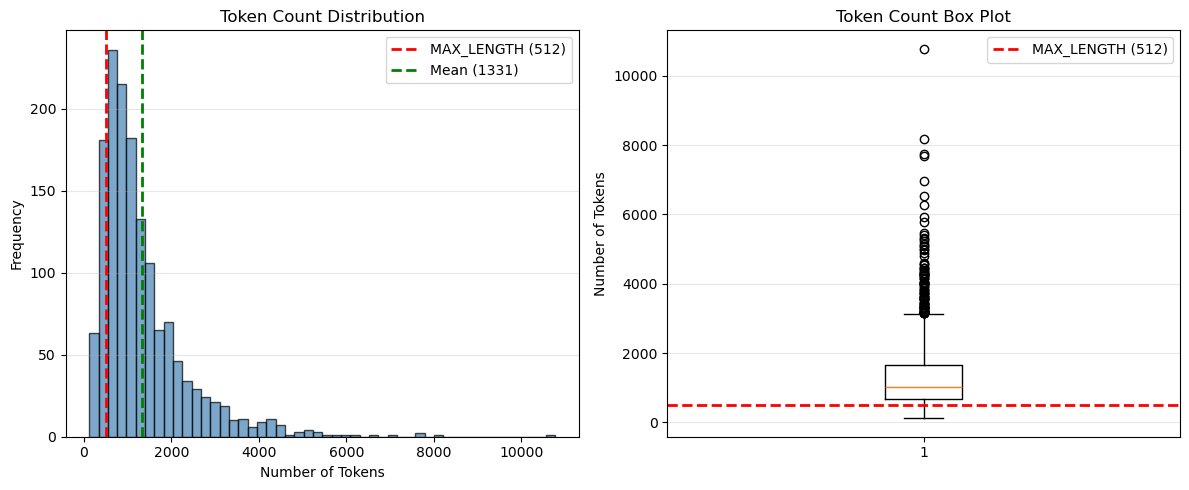

In [6]:
# Load dataset to inspect samples
sample_dataset = FixationsDataset(DATA_PATH)

# Calculate token statistics for all samples
print("Calculating token statistics for all samples...")
print("="*80)

token_counts = []

for i in tqdm(range(len(sample_dataset)), desc="Tokenizing samples"):
    sample = sample_dataset[i]
    text = sample['text']
    
    # Tokenize the text
    tokens = tokenizer(text, truncation=False, add_special_tokens=False)
    token_count = len(tokens['input_ids'])
    token_counts.append(token_count)

# Convert to numpy array for statistics
token_counts = np.array(token_counts)

# Calculate statistics
print(f"\nToken Count Statistics:")
print(f"  Total samples: {len(token_counts)}")
print(f"  Mean: {token_counts.mean():.2f}")
print(f"  Std: {token_counts.std():.2f}")
print(f"  Min: {token_counts.min()}")
print(f"  Max: {token_counts.max()}")
print(f"  Median: {np.median(token_counts):.2f}")
print(f"  25th percentile: {np.percentile(token_counts, 25):.2f}")
print(f"  75th percentile: {np.percentile(token_counts, 75):.2f}")
print(f"  95th percentile: {np.percentile(token_counts, 95):.2f}")
print(f"  99th percentile: {np.percentile(token_counts, 99):.2f}")

# Check how many samples exceed MAX_LENGTH
truncated_count = np.sum(token_counts > MAX_LENGTH)
print(f"\nSamples exceeding MAX_LENGTH ({MAX_LENGTH}): {truncated_count} ({100*truncated_count/len(token_counts):.2f}%)")

# Plot histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.axvline(x=token_counts.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean ({token_counts.mean():.0f})')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.legend() 
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(token_counts, vert=True)
plt.axhline(y=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.ylabel('Number of Tokens')
plt.title('Token Count Box Plot')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Collate Function

Tokenize text sequences and prepare batch for BERT.

In [8]:
def collate_fn(batch):
    """Collate function for DataLoader with tokenization."""
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    user_ids = [item['user_id'] for item in batch]
    
    # Tokenize texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels,
        'user_ids': user_ids
    }

## Training Function

In [9]:
def train_model(model, train_loader, optimizer, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

## Evaluation Function

In [10]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set."""
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

## LOUO Cross-Validation

Leave-One-User-Out: Train on all users except one, test on the held-out user.

In [11]:
# Load full dataset
print("Loading dataset...")
full_dataset = FixationsDataset(DATA_PATH)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get unique users for LOUO
unique_users = full_dataset.get_unique_users()
print(f"Found {len(unique_users)} unique users: {unique_users}")

# Storage for results
all_fold_results = []

# LOUO Cross-Validation
for fold, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"Fold {fold+1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset by user
    train_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id != test_user]
    test_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id == test_user]
    
    print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")
    
    # Handle edge case: no test samples
    if len(test_indices) == 0:
        print(f"Warning: No test samples for user {test_user}, skipping...")
        continue
    
    # Create subsets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Initialize model for this fold
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        
    )
    
    # Resize token embeddings to account for [ROW] token
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    best_val_f1 = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # Evaluate
        results = evaluate_model(model, test_loader, device)
        print(f"Test Loss: {results['loss']:.4f}")
        print(f"Test Acc: {results['accuracy']:.4f}")
        print(f"Test Precision: {results['precision']:.4f}")
        print(f"Test Recall: {results['recall']:.4f}")
        print(f"Test F1: {results['f1']:.4f}")
    
    # Store final results for this fold
    final_results = evaluate_model(model, test_loader, device)
    final_results['test_user'] = test_user
    final_results['fold'] = fold
    all_fold_results.append(final_results)
    
    # Clean up
    del model, optimizer
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("LOUO Cross-Validation Complete!")
print(f"{'='*60}")

Loading dataset...
Loaded 1499 samples from 30 users
Label distribution - Literate: 650, Illiterate: 849
Using device: cuda
Found 30 unique users: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.30it/s]


Train Loss: 0.6575, Train Acc: 0.5880


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.30it/s]


Test Loss: 2.7340
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.53it/s]


Train Loss: 0.5254, Train Acc: 0.7329


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.21it/s]


Test Loss: 2.3226
Test Acc: 0.0600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.48it/s]


Train Loss: 0.4518, Train Acc: 0.7937


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.10it/s]


Test Loss: 2.5462
Test Acc: 0.1200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.3889, Train Acc: 0.8268


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.19it/s]


Test Loss: 1.2371
Test Acc: 0.5400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.3155, Train Acc: 0.8737


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.57it/s]


Test Loss: 3.0016
Test Acc: 0.0600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.38it/s]



Fold 2/30 - Testing on User 2
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6938, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.25it/s]


Test Loss: 0.5124
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.6893, Train Acc: 0.5459


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.65it/s]


Test Loss: 0.7095
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6916, Train Acc: 0.5473


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.69it/s]


Test Loss: 0.5300
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.34it/s]


Train Loss: 0.6991, Train Acc: 0.5480


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.89it/s]


Test Loss: 0.5575
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.31it/s]


Train Loss: 0.6952, Train Acc: 0.5438


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.90it/s]


Test Loss: 0.5570
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.91it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 3/30 - Testing on User 3
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.57it/s]


Train Loss: 0.6945, Train Acc: 0.5204


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 24.99it/s]


Test Loss: 0.8878
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.57it/s]


Train Loss: 0.6260, Train Acc: 0.6391


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 25.01it/s]


Test Loss: 0.5515
Test Acc: 0.6200
Test Precision: 1.0000
Test Recall: 0.6200
Test F1: 0.7654

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.56it/s]


Train Loss: 0.5417, Train Acc: 0.7371


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 25.17it/s]


Test Loss: 1.4549
Test Acc: 0.0200
Test Precision: 1.0000
Test Recall: 0.0200
Test F1: 0.0392

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.61it/s]


Train Loss: 0.4820, Train Acc: 0.7771


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 24.97it/s]


Test Loss: 0.7510
Test Acc: 0.6400
Test Precision: 1.0000
Test Recall: 0.6400
Test F1: 0.7805

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.59it/s]


Train Loss: 0.4280, Train Acc: 0.7999


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 25.20it/s]


Test Loss: 1.5803
Test Acc: 0.2200
Test Precision: 1.0000
Test Recall: 0.2200
Test F1: 0.3607


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 25.22it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 4/30 - Testing on User 4
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.6420, Train Acc: 0.6273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.35it/s]


Test Loss: 1.4781
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.5340, Train Acc: 0.7343


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.80it/s]


Test Loss: 0.5591
Test Acc: 0.7800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.41it/s]


Train Loss: 0.4021, Train Acc: 0.8123


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.84it/s]


Test Loss: 0.9882
Test Acc: 0.4200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.3177, Train Acc: 0.8640


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.75it/s]


Test Loss: 0.6223
Test Acc: 0.6600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.39it/s]


Train Loss: 0.2246, Train Acc: 0.9117


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.82it/s]


Test Loss: 0.4862
Test Acc: 0.8200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.58it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 5/30 - Testing on User 6
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6692, Train Acc: 0.5735


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.48it/s]


Test Loss: 1.1598
Test Acc: 0.0200
Test Precision: 1.0000
Test Recall: 0.0200
Test F1: 0.0392

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.31it/s]


Train Loss: 0.5659, Train Acc: 0.7129


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.64it/s]


Test Loss: 0.6844
Test Acc: 0.5600
Test Precision: 1.0000
Test Recall: 0.5600
Test F1: 0.7179

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.31it/s]


Train Loss: 0.4600, Train Acc: 0.7992


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.13it/s]


Test Loss: 0.2157
Test Acc: 0.9600
Test Precision: 1.0000
Test Recall: 0.9600
Test F1: 0.9796

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.3958, Train Acc: 0.8323


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 48.83it/s]


Test Loss: 0.3620
Test Acc: 0.8600
Test Precision: 1.0000
Test Recall: 0.8600
Test F1: 0.9247

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.3245, Train Acc: 0.8696


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.67it/s]


Test Loss: 0.3859
Test Acc: 0.8200
Test Precision: 1.0000
Test Recall: 0.8200
Test F1: 0.9011


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.69it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 6/30 - Testing on User 7
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6877, Train Acc: 0.5424


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.04it/s]


Test Loss: 0.4484
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.5966, Train Acc: 0.7019


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 36.53it/s]


Test Loss: 0.0886
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.5223, Train Acc: 0.7398


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 36.90it/s]


Test Loss: 0.0404
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.45it/s]


Train Loss: 0.4273, Train Acc: 0.8095


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 36.96it/s]


Test Loss: 0.0531
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.3359, Train Acc: 0.8599


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 36.78it/s]


Test Loss: 0.1092
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 36.69it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 7/30 - Testing on User 8
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.6556, Train Acc: 0.6059


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.63it/s]


Test Loss: 0.4402
Test Acc: 1.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.5142, Train Acc: 0.7529


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.69it/s]


Test Loss: 1.4866
Test Acc: 0.3400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.4026, Train Acc: 0.8261


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.99it/s]


Test Loss: 1.1277
Test Acc: 0.4600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.3145, Train Acc: 0.8785


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.97it/s]


Test Loss: 1.9713
Test Acc: 0.4000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.2594, Train Acc: 0.8979


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.43it/s]


Test Loss: 2.0021
Test Acc: 0.3400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.69it/s]



Fold 8/30 - Testing on User 9
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.41it/s]


Train Loss: 0.6936, Train Acc: 0.5576


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.80it/s]


Test Loss: 0.9750
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6923, Train Acc: 0.5604


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.86it/s]


Test Loss: 0.8132
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6853, Train Acc: 0.5631


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.89it/s]


Test Loss: 1.0585
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.42it/s]


Train Loss: 0.6820, Train Acc: 0.5680


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.09it/s]


Test Loss: 0.9001
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6864, Train Acc: 0.5756


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.47it/s]


Test Loss: 1.0401
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.95it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 9/30 - Testing on User 10
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.6873, Train Acc: 0.5590


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.36it/s]


Test Loss: 1.1548
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.39it/s]


Train Loss: 0.6332, Train Acc: 0.6301


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.31it/s]


Test Loss: 0.9991
Test Acc: 0.3600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.5164, Train Acc: 0.7488


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.35it/s]


Test Loss: 1.4051
Test Acc: 0.1000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.4055, Train Acc: 0.8157


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 44.91it/s]


Test Loss: 3.1619
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.33it/s]


Train Loss: 0.3034, Train Acc: 0.8765


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 45.28it/s]


Test Loss: 2.2914
Test Acc: 0.2000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 44.98it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 10/30 - Testing on User 11
Train samples: 1450, Test samples: 49

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.33it/s]


Train Loss: 0.7029, Train Acc: 0.5359


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.57it/s]


Test Loss: 0.7103
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6983, Train Acc: 0.5276


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.86it/s]


Test Loss: 0.5357
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6600, Train Acc: 0.6152


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.78it/s]


Test Loss: 0.6524
Test Acc: 0.8163
Test Precision: 1.0000
Test Recall: 0.8163
Test F1: 0.8989

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6018, Train Acc: 0.6772


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.73it/s]


Test Loss: 0.2167
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.5235, Train Acc: 0.7517


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.74it/s]


Test Loss: 0.1123
Test Acc: 0.9796
Test Precision: 1.0000
Test Recall: 0.9796
Test F1: 0.9897


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.91it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 11/30 - Testing on User 12
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.51it/s]


Train Loss: 0.7005, Train Acc: 0.5238


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.24it/s]


Test Loss: 0.6288
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.53it/s]


Train Loss: 0.6975, Train Acc: 0.5397


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.13it/s]


Test Loss: 0.8210
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.52it/s]


Train Loss: 0.6981, Train Acc: 0.5383


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.23it/s]


Test Loss: 0.6201
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.51it/s]


Train Loss: 0.6954, Train Acc: 0.5411


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.21it/s]


Test Loss: 0.4813
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.53it/s]


Train Loss: 0.7010, Train Acc: 0.5238


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.12it/s]


Test Loss: 0.4697
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.22it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 12/30 - Testing on User 13
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.39it/s]


Train Loss: 0.6862, Train Acc: 0.5459


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.72it/s]


Test Loss: 0.4728
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.5933, Train Acc: 0.6598


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.74it/s]


Test Loss: 0.1455
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.42it/s]


Train Loss: 0.4805, Train Acc: 0.7743


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.32it/s]


Test Loss: 0.1789
Test Acc: 0.9600
Test Precision: 1.0000
Test Recall: 0.9600
Test F1: 0.9796

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.3874, Train Acc: 0.8344


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.79it/s]


Test Loss: 0.0992
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.3145, Train Acc: 0.8703


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.84it/s]


Test Loss: 0.0061
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 41.10it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 13/30 - Testing on User 14
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.6889, Train Acc: 0.5466


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.59it/s]


Test Loss: 1.1408
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6316, Train Acc: 0.6398


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.59it/s]


Test Loss: 1.1535
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.47it/s]


Train Loss: 0.6727, Train Acc: 0.5956


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.54it/s]


Test Loss: 0.6083
Test Acc: 1.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.6764, Train Acc: 0.5721


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.32it/s]


Test Loss: 0.7476
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.6229, Train Acc: 0.6356


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.64it/s]


Test Loss: 0.9436
Test Acc: 0.4800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.58it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 14/30 - Testing on User 15
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6872, Train Acc: 0.5376


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.10it/s]


Test Loss: 0.1929
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6835, Train Acc: 0.5549


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.11it/s]


Test Loss: 0.7715
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.6646, Train Acc: 0.5790


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.04it/s]


Test Loss: 0.4328
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.32it/s]


Train Loss: 0.5771, Train Acc: 0.6922


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.32it/s]


Test Loss: 0.3413
Test Acc: 0.8400
Test Precision: 1.0000
Test Recall: 0.8400
Test F1: 0.9130

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.5197, Train Acc: 0.7571


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.09it/s]


Test Loss: 0.3371
Test Acc: 0.8800
Test Precision: 1.0000
Test Recall: 0.8800
Test F1: 0.9362


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.37it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 15/30 - Testing on User 16
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.6634, Train Acc: 0.5845


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.59it/s]


Test Loss: 1.8215
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.6329, Train Acc: 0.6356


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.69it/s]


Test Loss: 1.3814
Test Acc: 0.1200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.5239, Train Acc: 0.7543


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.72it/s]


Test Loss: 1.2827
Test Acc: 0.4200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.44it/s]


Train Loss: 0.4168, Train Acc: 0.8171


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.35it/s]


Test Loss: 1.0017
Test Acc: 0.4600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.3151, Train Acc: 0.8785


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.48it/s]


Test Loss: 1.6702
Test Acc: 0.2800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.72it/s]



Fold 16/30 - Testing on User 17
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.28it/s]


Train Loss: 0.6785, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 60.88it/s]


Test Loss: 1.2755
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.29it/s]


Train Loss: 0.6074, Train Acc: 0.6936


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 59.58it/s]


Test Loss: 0.4446
Test Acc: 0.8200
Test Precision: 1.0000
Test Recall: 0.8200
Test F1: 0.9011

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.29it/s]


Train Loss: 0.5697, Train Acc: 0.7012


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 60.79it/s]


Test Loss: 0.3462
Test Acc: 0.8600
Test Precision: 1.0000
Test Recall: 0.8600
Test F1: 0.9247

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.30it/s]


Train Loss: 0.5017, Train Acc: 0.7695


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 60.30it/s]


Test Loss: 0.2573
Test Acc: 0.9200
Test Precision: 1.0000
Test Recall: 0.9200
Test F1: 0.9583

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.31it/s]


Train Loss: 0.4419, Train Acc: 0.7985


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 61.14it/s]


Test Loss: 0.6614
Test Acc: 0.6800
Test Precision: 1.0000
Test Recall: 0.6800
Test F1: 0.8095


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 59.64it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 17/30 - Testing on User 18
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.26it/s]


Train Loss: 0.6996, Train Acc: 0.5307


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.21it/s]


Test Loss: 0.7429
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.27it/s]


Train Loss: 0.7014, Train Acc: 0.5204


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.03it/s]


Test Loss: 0.6359
Test Acc: 0.8200
Test Precision: 1.0000
Test Recall: 0.8200
Test F1: 0.9011

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.29it/s]


Train Loss: 0.6673, Train Acc: 0.5949


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.53it/s]


Test Loss: 0.3918
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.24it/s]


Train Loss: 0.6365, Train Acc: 0.6446


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.28it/s]


Test Loss: 0.2178
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.27it/s]


Train Loss: 0.6293, Train Acc: 0.6563


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 32.38it/s]


Test Loss: 0.5808
Test Acc: 0.6000
Test Precision: 1.0000
Test Recall: 0.6000
Test F1: 0.7500


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.56it/s]



Fold 18/30 - Testing on User 19
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.21it/s]


Train Loss: 0.6872, Train Acc: 0.5597


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 37.75it/s]


Test Loss: 0.7452
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.23it/s]


Train Loss: 0.5664, Train Acc: 0.7046


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.83it/s]


Test Loss: 1.6502
Test Acc: 0.0200
Test Precision: 1.0000
Test Recall: 0.0200
Test F1: 0.0392

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.17it/s]


Train Loss: 0.4755, Train Acc: 0.7757


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.65it/s]


Test Loss: 0.7822
Test Acc: 0.6400
Test Precision: 1.0000
Test Recall: 0.6400
Test F1: 0.7805

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.19it/s]


Train Loss: 0.3952, Train Acc: 0.8137


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.04it/s]


Test Loss: 1.1438
Test Acc: 0.4200
Test Precision: 1.0000
Test Recall: 0.4200
Test F1: 0.5915

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.3151, Train Acc: 0.8716


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.99it/s]


Test Loss: 0.8709
Test Acc: 0.5600
Test Precision: 1.0000
Test Recall: 0.5600
Test F1: 0.7179


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.59it/s]



Fold 19/30 - Testing on User 21
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.49it/s]


Train Loss: 0.6881, Train Acc: 0.5645


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.03it/s]


Test Loss: 0.9047
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.50it/s]


Train Loss: 0.6944, Train Acc: 0.5597


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 33.83it/s]


Test Loss: 0.8726
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.49it/s]


Train Loss: 0.6889, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.06it/s]


Test Loss: 0.8792
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.6878, Train Acc: 0.5694


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 33.71it/s]


Test Loss: 1.0080
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.46it/s]


Train Loss: 0.6881, Train Acc: 0.5694


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 33.58it/s]


Test Loss: 0.7755
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 33.77it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 20/30 - Testing on User 22
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.41it/s]


Train Loss: 0.6930, Train Acc: 0.5411


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.64it/s]


Test Loss: 0.6520
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.41it/s]


Train Loss: 0.6842, Train Acc: 0.5438


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.62it/s]


Test Loss: 0.3520
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.6958, Train Acc: 0.5286


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.39it/s]


Test Loss: 0.5826
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.39it/s]


Train Loss: 0.6881, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.46it/s]


Test Loss: 0.5485
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6908, Train Acc: 0.5252


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.48it/s]


Test Loss: 0.5183
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.02it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 21/30 - Testing on User 23
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.34it/s]


Train Loss: 0.6800, Train Acc: 0.5714


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.37it/s]


Test Loss: 1.1488
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.6859, Train Acc: 0.5680


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.40it/s]


Test Loss: 1.0471
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.6409, Train Acc: 0.6170


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.26it/s]


Test Loss: 0.6680
Test Acc: 0.4600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.5919, Train Acc: 0.6943


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.46it/s]


Test Loss: 0.4911
Test Acc: 0.6400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.5368, Train Acc: 0.7329


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.70it/s]


Test Loss: 0.5068
Test Acc: 0.7800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.47it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 22/30 - Testing on User 24
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.50it/s]


Train Loss: 0.6224, Train Acc: 0.6453


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.22it/s]


Test Loss: 1.2252
Test Acc: 0.1400
Test Precision: 1.0000
Test Recall: 0.1400
Test F1: 0.2456

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.49it/s]


Train Loss: 0.4806, Train Acc: 0.7792


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.33it/s]


Test Loss: 2.5465
Test Acc: 0.0200
Test Precision: 1.0000
Test Recall: 0.0200
Test F1: 0.0392

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.49it/s]


Train Loss: 0.3570, Train Acc: 0.8537


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 29.74it/s]


Test Loss: 2.0935
Test Acc: 0.2600
Test Precision: 1.0000
Test Recall: 0.2600
Test F1: 0.4127

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.48it/s]


Train Loss: 0.2600, Train Acc: 0.9075


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.12it/s]


Test Loss: 2.2986
Test Acc: 0.1800
Test Precision: 1.0000
Test Recall: 0.1800
Test F1: 0.3051

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.48it/s]


Train Loss: 0.2054, Train Acc: 0.9282


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.08it/s]


Test Loss: 0.9044
Test Acc: 0.6000
Test Precision: 1.0000
Test Recall: 0.6000
Test F1: 0.7500


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 30.01it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 23/30 - Testing on User 25
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6879, Train Acc: 0.5625


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.44it/s]


Test Loss: 0.4312
Test Acc: 0.8600
Test Precision: 1.0000
Test Recall: 0.8600
Test F1: 0.9247

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.20it/s]


Train Loss: 0.6158, Train Acc: 0.6536


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.00it/s]


Test Loss: 0.6235
Test Acc: 0.7400
Test Precision: 1.0000
Test Recall: 0.7400
Test F1: 0.8506

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.17it/s]


Train Loss: 0.5364, Train Acc: 0.7129


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 42.67it/s]


Test Loss: 2.4832
Test Acc: 0.0200
Test Precision: 1.0000
Test Recall: 0.0200
Test F1: 0.0392

Epoch 4/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.35it/s]


Train Loss: 0.4624, Train Acc: 0.7847


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 40.84it/s]


Test Loss: 1.5204
Test Acc: 0.4000
Test Precision: 1.0000
Test Recall: 0.4000
Test F1: 0.5714

Epoch 5/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.33it/s]


Train Loss: 0.4070, Train Acc: 0.8102


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 44.00it/s]


Test Loss: 3.8874
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 42.19it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 24/30 - Testing on User 26
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.48it/s]


Train Loss: 0.6829, Train Acc: 0.5832


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.66it/s]


Test Loss: 1.0912
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.6823, Train Acc: 0.5776


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 40.09it/s]


Test Loss: 0.7326
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.6877, Train Acc: 0.5776


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 40.23it/s]


Test Loss: 0.8713
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.43it/s]


Train Loss: 0.6850, Train Acc: 0.5769


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.94it/s]


Test Loss: 1.0746
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.45it/s]


Train Loss: 0.6867, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.56it/s]


Test Loss: 0.8274
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.86it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 25/30 - Testing on User 27
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.39it/s]


Train Loss: 0.6515, Train Acc: 0.5990


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.66it/s]


Test Loss: 1.1227
Test Acc: 0.1800
Test Precision: 1.0000
Test Recall: 0.1800
Test F1: 0.3051

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.5235, Train Acc: 0.7398


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.62it/s]


Test Loss: 0.4602
Test Acc: 0.7800
Test Precision: 1.0000
Test Recall: 0.7800
Test F1: 0.8764

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.40it/s]


Train Loss: 0.4344, Train Acc: 0.8040


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.42it/s]


Test Loss: 0.7405
Test Acc: 0.5800
Test Precision: 1.0000
Test Recall: 0.5800
Test F1: 0.7342

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.2979, Train Acc: 0.8785


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 46.90it/s]


Test Loss: 0.7844
Test Acc: 0.5000
Test Precision: 1.0000
Test Recall: 0.5000
Test F1: 0.6667

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.38it/s]


Train Loss: 0.2234, Train Acc: 0.9061


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.28it/s]


Test Loss: 0.0929
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.05it/s]



Fold 26/30 - Testing on User 28
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6438, Train Acc: 0.6322


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.79it/s]


Test Loss: 1.2785
Test Acc: 0.2000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.34it/s]


Train Loss: 0.5467, Train Acc: 0.7212


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.53it/s]


Test Loss: 1.2571
Test Acc: 0.2400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.4476, Train Acc: 0.7909


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.57it/s]


Test Loss: 0.6431
Test Acc: 0.6200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.48it/s]


Train Loss: 0.3232, Train Acc: 0.8696


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 48.41it/s]


Test Loss: 1.1304
Test Acc: 0.4200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.53it/s]


Train Loss: 0.2455, Train Acc: 0.9103


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.19it/s]


Test Loss: 2.0206
Test Acc: 0.1800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 51.60it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 27/30 - Testing on User 29
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:20<00:00, 18.12it/s]


Train Loss: 0.6686, Train Acc: 0.5811


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 42.49it/s]


Test Loss: 1.2411
Test Acc: 0.1400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.18it/s]


Train Loss: 0.5552, Train Acc: 0.7177


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.96it/s]


Test Loss: 0.9795
Test Acc: 0.3200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:21<00:00, 17.27it/s]


Train Loss: 0.4421, Train Acc: 0.8019


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.62it/s]


Test Loss: 1.9677
Test Acc: 0.3200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.35it/s]


Train Loss: 0.3539, Train Acc: 0.8523


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.44it/s]


Test Loss: 1.9785
Test Acc: 0.3200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.38it/s]


Train Loss: 0.2762, Train Acc: 0.8896


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 38.85it/s]


Test Loss: 2.0960
Test Acc: 0.3200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 39.35it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 28/30 - Testing on User 30
Train samples: 1449, Test samples: 50

Epoch 1/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.38it/s]


Train Loss: 0.7025, Train Acc: 0.5307


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 31.37it/s]


Test Loss: 0.6014
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.79it/s]


Train Loss: 0.6928, Train Acc: 0.5383


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.39it/s]


Test Loss: 0.5838
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.20it/s]


Train Loss: 0.6616, Train Acc: 0.6218


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.10it/s]


Test Loss: 0.7525
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.23it/s]


Train Loss: 0.6010, Train Acc: 0.6680


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.00it/s]


Test Loss: 0.6984
Test Acc: 0.5200
Test Precision: 1.0000
Test Recall: 0.5200
Test F1: 0.6842

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.30it/s]


Train Loss: 0.5349, Train Acc: 0.7474


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.41it/s]


Test Loss: 0.7066
Test Acc: 0.6600
Test Precision: 1.0000
Test Recall: 0.6600
Test F1: 0.7952


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 34.42it/s]



Fold 29/30 - Testing on User 31
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.71it/s]


Train Loss: 0.6931, Train Acc: 0.5604


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.40it/s]


Test Loss: 0.8006
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.29it/s]


Train Loss: 0.6871, Train Acc: 0.5514


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 47.47it/s]


Test Loss: 0.8543
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.29it/s]


Train Loss: 0.6898, Train Acc: 0.5776


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 49.02it/s]


Test Loss: 0.9758
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.31it/s]


Train Loss: 0.6891, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.68it/s]


Test Loss: 0.9176
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.30it/s]


Train Loss: 0.6900, Train Acc: 0.5625


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 48.36it/s]


Test Loss: 0.8844
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 50.93it/s]



Fold 30/30 - Testing on User 32
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:20<00:00, 17.98it/s]


Train Loss: 0.7031, Train Acc: 0.5204


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.47it/s]


Test Loss: 0.4712
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.35it/s]


Train Loss: 0.6985, Train Acc: 0.5266


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.72it/s]


Test Loss: 0.6289
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.36it/s]


Train Loss: 0.6976, Train Acc: 0.5280


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.55it/s]


Test Loss: 0.5979
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.37it/s]


Train Loss: 0.6536, Train Acc: 0.5914


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.79it/s]


Test Loss: 0.2466
Test Acc: 0.9600
Test Precision: 1.0000
Test Recall: 0.9600
Test F1: 0.9796

Epoch 5/5


Training: 100%|██████████| 363/363 [00:19<00:00, 18.34it/s]


Train Loss: 0.5474, Train Acc: 0.7371


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.59it/s]


Test Loss: 0.6520
Test Acc: 0.5600
Test Precision: 1.0000
Test Recall: 0.5600
Test F1: 0.7179


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 52.66it/s]


LOUO Cross-Validation Complete!


## Aggregate Results Across Folds

In [12]:
# Calculate mean and std across all folds
if len(all_fold_results) > 0:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    print("\n" + "="*60)
    print("LOUO Cross-Validation Results Summary")
    print("="*60)
    
    for metric in metrics:
        values = [result[metric] for result in all_fold_results]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize():12s}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame([
        {
            'fold': r['fold'],
            'test_user': r['test_user'],
            'accuracy': r['accuracy'],
            'precision': r['precision'],
            'recall': r['recall'],
            'f1': r['f1']
        }
        for r in all_fold_results
    ])
    
    print("\nPer-Fold Results:")
    print(results_df.to_string(index=False))
else:
    print("No results to aggregate")


LOUO Cross-Validation Results Summary
Accuracy    : 0.5333 ± 0.3657
Precision   : 0.5333 ± 0.4989
Recall      : 0.4180 ± 0.4250
F1          : 0.4573 ± 0.4453

Per-Fold Results:
 fold  test_user  accuracy  precision   recall       f1
    0          1  0.060000        0.0 0.000000 0.000000
    1          2  1.000000        1.0 1.000000 1.000000
    2          3  0.220000        1.0 0.220000 0.360656
    3          4  0.820000        0.0 0.000000 0.000000
    4          6  0.820000        1.0 0.820000 0.901099
    5          7  0.980000        1.0 0.980000 0.989899
    6          8  0.340000        0.0 0.000000 0.000000
    7          9  0.000000        0.0 0.000000 0.000000
    8         10  0.200000        0.0 0.000000 0.000000
    9         11  0.979592        1.0 0.979592 0.989691
   10         12  1.000000        1.0 1.000000 1.000000
   11         13  1.000000        1.0 1.000000 1.000000
   12         14  0.480000        0.0 0.000000 0.000000
   13         15  0.880000        1.0 

## Visualize Results

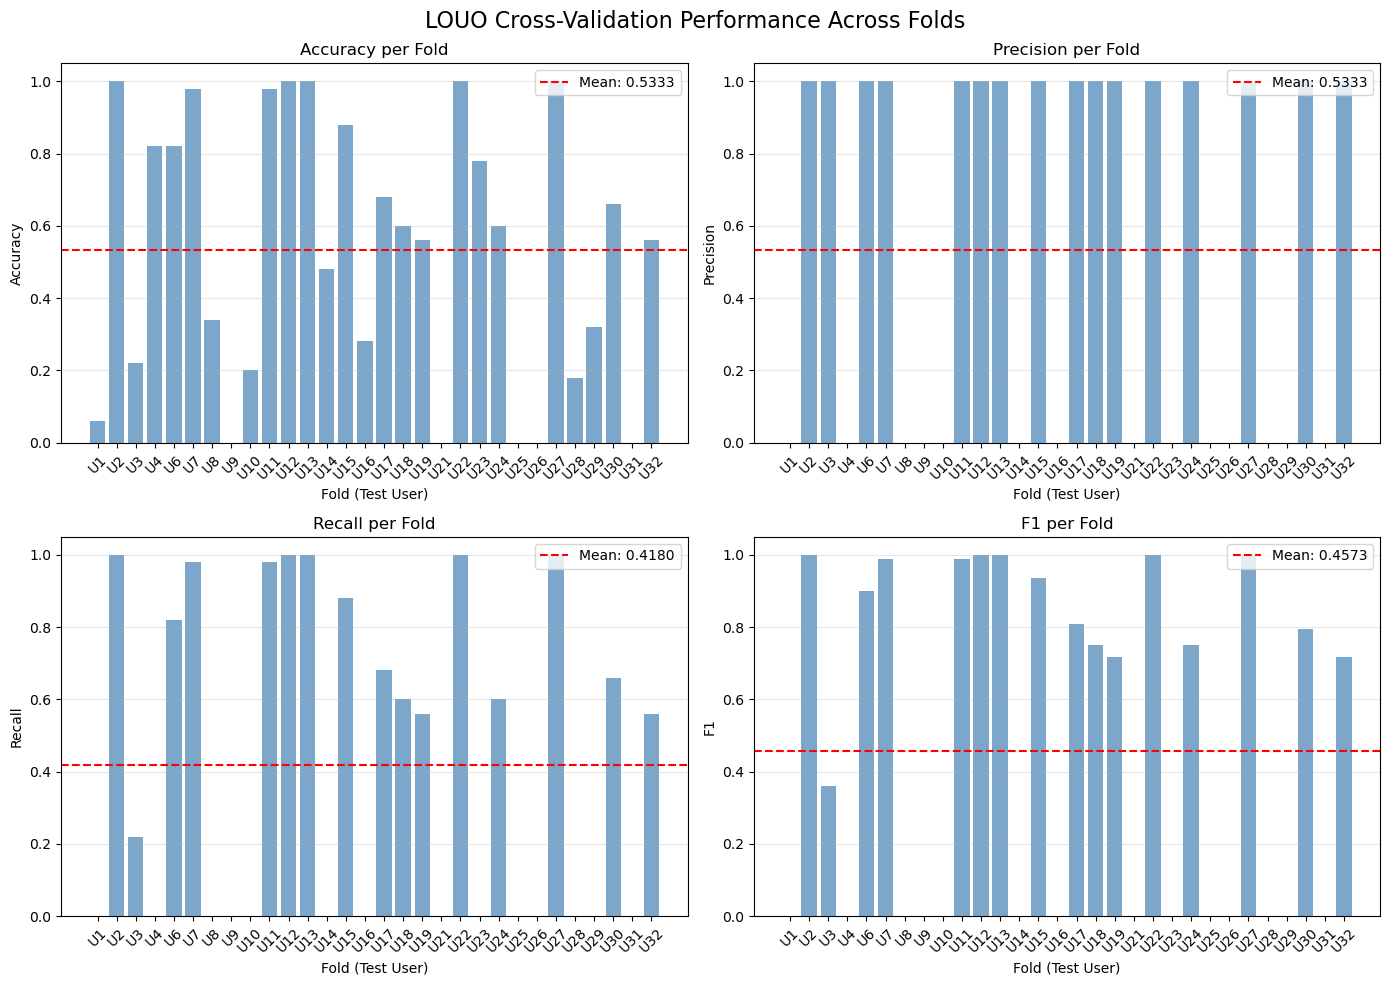

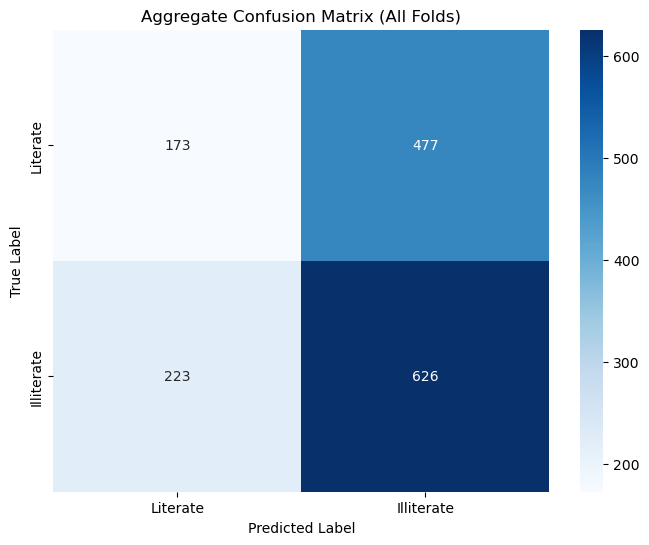

In [13]:
if len(all_fold_results) > 0:
    # Plot metrics across folds
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('LOUO Cross-Validation Performance Across Folds', fontsize=16)
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        values = [result[metric] for result in all_fold_results]
        users = [result['test_user'] for result in all_fold_results]
        
        ax.bar(range(len(values)), values, color='steelblue', alpha=0.7)
        ax.axhline(y=np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.4f}')
        ax.set_xlabel('Fold (Test User)')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} per Fold')
        ax.set_xticks(range(len(users)))
        ax.set_xticklabels([f"U{u}" for u in users], rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix (aggregate)
    all_predictions = []
    all_labels = []
    for result in all_fold_results:
        all_predictions.extend(result['predictions'])
        all_labels.extend(result['labels'])
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Literate', 'Illiterate'],
                yticklabels=['Literate', 'Illiterate'])
    plt.title('Aggregate Confusion Matrix (All Folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("No results to visualize")